# Module 3: Descriptors
## Part 1: Dimensional reduction and classification

In this notebook, we illustrate the use dimensional reduction and classification algorithms starting from descriptors

### 1. Install and load python libraries

In [ ]:
!pip install numpy matplotlib ase scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase.io as aseio
from ase.geometry.analysis import Analysis
from ase.visualize import view
from sklearn.manifold import TSNE

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
!git clone https://github.com/AMLS-PRG/AtomML-Course
modelpath='AtomML-Course/module-4/01-dimensionality-reduction-and-classification/model/frozen_model_1.pb'

### 2. Visualize configurations

Let's start with ice

In [2]:
filename = "AtomML-Course/module-4/01-dimensionality-reduction-and-classification/trajectories/ice.lammps-dump-text"
atoms = aseio.read(filename,format='lammps-dump-text',index="-1")
symbols=np.array(atoms.get_chemical_symbols())
symbols[symbols=='Be']='O'
symbols[symbols=='B']='H'
atoms.set_chemical_symbols(symbols)
view(atoms,viewer='x3d')

Let's continue with liquid water

In [3]:
filename = "AtomML-Course/module-4/01-dimensionality-reduction-and-classification/trajectories/water.lammps-dump-text"
atoms = aseio.read(filename,format='lammps-dump-text',index="-1")
symbols=np.array(atoms.get_chemical_symbols())
symbols[symbols=='Be']='O'
symbols[symbols=='B']='H'
atoms.set_chemical_symbols(symbols)
view(atoms,viewer='x3d')

Can you observe differences between the two structures? Which ones?

### 3. Use ASE and DeePMD to compute descriptors from trajectories
This section can be skipped and computed descriptors can be loaded directly. We start from a trajectory of a molecular dynamics simulation of water at around room temperature and atmospheric pressure. The simulation was carried out using a machine learning model for the interatomic interactions.

In [ ]:
# Install libraries to compute descriptors
!pip install -q deepmd-kit[cpu] dpdata
import dpdata
from deepmd.calculator import DP
from deepmd.infer import DeepPot

In [ ]:
# Read file
filename = "AtomML-Course/module-4/01-dimensionality-reduction-and-classification/trajectories/ice.lammps-dump-text"
atoms = aseio.read(filename,format='lammps-dump-text',index="-1")
symbols=np.array(atoms.get_chemical_symbols())
symbols[symbols=='Be']='O'
symbols[symbols=='B']='H'
atoms.set_chemical_symbols(symbols)
atoms.calc = DP(model=modelpath)
system = dpdata.LabeledSystem(atoms, fmt = 'ase/structure')
dp = DeepPot(modelpath)
d_ice = dp.eval_descriptor(system['coords'], system['cells'], system['atom_types'])[0]
symbols_ice = atoms.get_chemical_symbols()

In [ ]:
# Read file
filename = "AtomML-Course/module-4/01-dimensionality-reduction-and-classification/trajectories/water.lammps-dump-text"
atoms = aseio.read(filename,format='lammps-dump-text',index="-1")
symbols=np.array(atoms.get_chemical_symbols())
symbols[symbols=='Be']='O'
symbols[symbols=='B']='H'
atoms.set_chemical_symbols(symbols)
atoms.calc = DP(model=modelpath)
system = dpdata.LabeledSystem(atoms, fmt = 'ase/structure')
dp = DeepPot(modelpath)
d_water = dp.eval_descriptor(system['coords'], system['cells'], system['atom_types'])[0]
symbols_water = atoms.get_chemical_symbols()

In [20]:
step=2
descr = np.concatenate((d_ice,d_water))[::step,:]

phase_ice = np.zeros(d_ice.shape[0])
phase_water = np.ones(d_water.shape[0])
phase = np.concatenate((phase_ice,phase_water))[::step]

symbols = np.concatenate((np.array(symbols_ice),np.array(symbols_water)))
symbols[symbols=="O"]=0
symbols[symbols=="H"]=1
symbols = symbols.astype("float")[::step]

### 4. Perform dimensional reduction using t-SNE

In [21]:
# If you couldn't compute descriptors, load them here
#descr = np.load("AtomML-Course/module-4/01-dimensionality-reduction-and-classification/results-descriptors/descriptors.npy")
#phase = np.load("AtomML-Course/module-4/01-dimensionality-reduction-and-classification/results-descriptors/phase.npy") # 0 is ice, 1 is liquid water
#symbols = np.load("AtomML-Course/module-4/01-dimensionality-reduction-and-classification/results-descriptors/symbols.npy") # 0 is oxygen, 1 is hydrogen

In [22]:
my_tsne = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=3)
X_embedded = my_tsne.fit_transform(descr)

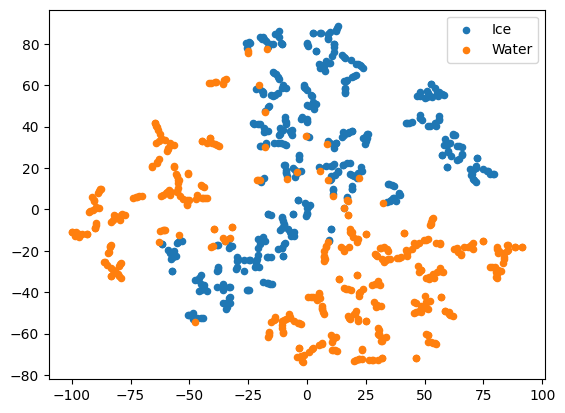

In [23]:
plt.scatter(X_embedded[phase==0,0],X_embedded[phase==0,1],s=20,color=colors[0],label="Ice")
plt.scatter(X_embedded[phase==1,0],X_embedded[phase==1,1],s=20,color=colors[1],label="Water")
plt.legend()
plt.show()

### EXERCISE:
Repeat plot above coloring the dots using the chemical elements, i.e., the ```symbols```

In [ ]:
#plt.scatter(...,s=20,color=colors[0],label="Oxygen")
#plt.scatter(...,s=20,color=colors[1],label="Hydrogen")
#plt.legend()

#plt.show()

Below we color both using the element and the phase

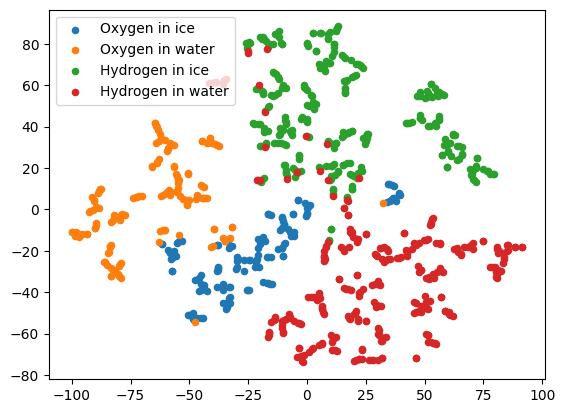

In [26]:
plt.scatter(X_embedded[np.logical_and(symbols==0,phase==0),0],X_embedded[np.logical_and(symbols==0,phase==0),1],s=20,color=colors[0],label="Oxygen in ice")
plt.scatter(X_embedded[np.logical_and(symbols==0,phase==1),0],X_embedded[np.logical_and(symbols==0,phase==1),1],s=20,color=colors[1],label="Oxygen in water")
plt.scatter(X_embedded[np.logical_and(symbols==1,phase==0),0],X_embedded[np.logical_and(symbols==1,phase==0),1],s=20,color=colors[2],label="Hydrogen in ice")
plt.scatter(X_embedded[np.logical_and(symbols==1,phase==1),0],X_embedded[np.logical_and(symbols==1,phase==1),1],s=20,color=colors[3],label="Hydrogen in water")
plt.legend()

plt.show()

### 6. Train classifiers to distinguish between water and ice environments

In [27]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    descr, phase, test_size=0.1, random_state=42)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [28]:
print(clf.predict(X_test)==y_test)

[ True  True  True False  True False  True False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True False  True]


Does the algorithm correctly classify water and ice environments?

## EXERCISE
Train a classification model using a multi-layer perceptron. Test the algorithm and compare.

In [29]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 25), random_state=1, max_iter=1000)
...

Ellipsis